# Entrenamiento de CNN con todos los conjuntos de MedMNIST

Este cuaderno prepara y entrena un modelo ResNet-18 capaz de clasificar de forma conjunta todos los conjuntos de MedMNIST. El flujo reutiliza el módulo `scripts/Train_CNNCL.py`

## Flujo de trabajo
- Importar utilidades y fijar una configuración reproducible
- Listar los datasets disponibles y definir la configuración de entrenamiento
- Preparar los *DataLoaders* combinando todos los conjuntos
- Construir el modelo CNN y los objetos de optimización
- Entrenar el modelo con seguimiento de métricas por época
- Evaluar en el conjunto de prueba y generar un reporte reutilizable

In [18]:
# Importaciones y configuración básica
import json
from pathlib import Path
from types import SimpleNamespace

import pandas as pd
import torch
import torch.nn as nn


from medmnist import INFO

from scripts.Train_CNNCL import (
    crear_cargadores,
    construir_modelo,
    recorrer_entrenamiento,
    evaluar_modelo,
    guardar_reporte,
    construir_scheduler,
    nn,
    Adam,
)

# Fijamos semillas para reproducibilidad básica
TORCH_SEED = 42
torch.manual_seed(TORCH_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(TORCH_SEED)

print(f"Versión de PyTorch: {torch.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")

Versión de PyTorch: 2.8.0+cpu
CUDA disponible: False


In [19]:
# Listado de datasets 2D de MedMNIST
# Filtramos los que no tienen '3d' en el nombre de su clase de Python
todos_los_datasets = sorted(
    nombre
    for nombre, info in INFO.items()
    if '3d' not in nombre.lower() and '3d' not in info.get('python_class', '').lower()
)
print(f"Total de datasets 2D: {len(todos_los_datasets)}")
todos_los_datasets

Total de datasets 2D: 12


['bloodmnist',
 'breastmnist',
 'chestmnist',
 'dermamnist',
 'octmnist',
 'organamnist',
 'organcmnist',
 'organsmnist',
 'pathmnist',
 'pneumoniamnist',
 'retinamnist',
 'tissuemnist']

In [20]:
# Configuración centralizada; ajusta hiperparámetros aquí
config = SimpleNamespace(
    datasets=todos_los_datasets,
    epocas=5,  # Incrementa si quieres un entrenamiento más largo
    tamano_lote=256,
    tasa_aprendizaje=1e-3,
    decaimiento_peso=1e-4,
    tamano_imagen=28,
    usar_aumentos=True,
    descargar=True,
    sin_preentrenar=False,
    dispositivo="cuda" if torch.cuda.is_available() else "cpu",
    salida="resultados/reporte_cnn_todos.json",
    trabajadores=4,
    scheduler="plateau",
    factor_scheduler=0.5,
    paciencia_scheduler=3,
)
config

namespace(datasets=['bloodmnist',
                    'breastmnist',
                    'chestmnist',
                    'dermamnist',
                    'octmnist',
                    'organamnist',
                    'organcmnist',
                    'organsmnist',
                    'pathmnist',
                    'pneumoniamnist',
                    'retinamnist',
                    'tissuemnist'],
          epocas=5,
          tamano_lote=256,
          tasa_aprendizaje=0.001,
          decaimiento_peso=0.0001,
          tamano_imagen=28,
          usar_aumentos=True,
          descargar=True,
          sin_preentrenar=False,
          dispositivo='cpu',
          salida='resultados/reporte_cnn_todos.json',
          trabajadores=4,
          scheduler='plateau',
          factor_scheduler=0.5,
          paciencia_scheduler=3)

# Preparar dataloaders combinando todos los conjuntos

In [22]:
(
    loader_entrenamiento,
    loader_validacion,
    loader_prueba,
    info_datasets,
) = crear_cargadores(
    nombres_dataset=config.datasets,
    tamano_lote=config.tamano_lote,
    descarga=config.descargar,
    tamano_imagen=config.tamano_imagen,
    usar_aumentos=config.usar_aumentos,
    trabajadores=config.trabajadores,
)

resumen_datos = {
    "train": len(loader_entrenamiento.dataset),
    "test": len(loader_prueba.dataset),
}
if loader_validacion is not None:
    resumen_datos["val"] = len(loader_validacion.dataset)

print("Resumen de muestras por partición:", resumen_datos)

total_clases = sum(info.clases for info in info_datasets.values())
print("Total de clases combinadas:", total_clases)

info_datasets

Resumen de muestras por partición: {'train': 518175, 'test': 119320, 'val': 70467}
Total de clases combinadas: 92


{'bloodmnist': RegistroDataset(nombre='bloodmnist', indice_inicial=0, clases=8),
 'breastmnist': RegistroDataset(nombre='breastmnist', indice_inicial=8, clases=2),
 'chestmnist': RegistroDataset(nombre='chestmnist', indice_inicial=10, clases=14),
 'dermamnist': RegistroDataset(nombre='dermamnist', indice_inicial=24, clases=7),
 'octmnist': RegistroDataset(nombre='octmnist', indice_inicial=31, clases=4),
 'organamnist': RegistroDataset(nombre='organamnist', indice_inicial=35, clases=11),
 'organcmnist': RegistroDataset(nombre='organcmnist', indice_inicial=46, clases=11),
 'organsmnist': RegistroDataset(nombre='organsmnist', indice_inicial=57, clases=11),
 'pathmnist': RegistroDataset(nombre='pathmnist', indice_inicial=68, clases=9),
 'pneumoniamnist': RegistroDataset(nombre='pneumoniamnist', indice_inicial=77, clases=2),
 'retinamnist': RegistroDataset(nombre='retinamnist', indice_inicial=79, clases=5),
 'tissuemnist': RegistroDataset(nombre='tissuemnist', indice_inicial=84, clases=8)}

# Construir modelo

In [23]:
dispositivo = torch.device(config.dispositivo)
print(f"Usando dispositivo: {dispositivo}")

modelo = construir_modelo(
    total_clases=total_clases,
    usar_pesos_imagenet=not config.sin_preentrenar,
)
modelo = modelo.to(dispositivo)

criterio = nn.CrossEntropyLoss()
optimizador = Adam(
    modelo.parameters(),
    lr=config.tasa_aprendizaje,
    weight_decay=config.decaimiento_peso,
)
scheduler = construir_scheduler(
    optimizador=optimizador,
    tipo_scheduler=config.scheduler,
    factor=config.factor_scheduler,
    paciencia=config.paciencia_scheduler,
)

modelo

Usando dispositivo: cpu


CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1152, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.

# Entrenar el modelo 

In [24]:
historial_entrenamiento, mejor_estado = recorrer_entrenamiento(
    modelo=modelo,
    cargador_entrenamiento=loader_entrenamiento,
    cargador_validacion=loader_validacion,
    criterio=criterio,
    optimizador=optimizador,
    scheduler=scheduler,
    epocas=config.epocas,
    dispositivo=dispositivo,
)

# Si hubo mejora en validación, recargamos el mejor estado
if mejor_estado:
    modelo.load_state_dict(mejor_estado)

historial_entrenamiento[:3]

[Epoca 001] Perdida ent: 1.2291 | Exactitud ent: 0.5919 | Perdida val: 0.9748 | Exactitud val: 0.6598
[Epoca 002] Perdida ent: 1.0132 | Exactitud ent: 0.6566 | Perdida val: 0.9145 | Exactitud val: 0.6851
[Epoca 003] Perdida ent: 0.9538 | Exactitud ent: 0.6771 | Perdida val: 0.8445 | Exactitud val: 0.7115
[Epoca 004] Perdida ent: 0.9135 | Exactitud ent: 0.6912 | Perdida val: 0.8527 | Exactitud val: 0.7034
[Epoca 005] Perdida ent: 0.8879 | Exactitud ent: 0.7009 | Perdida val: 0.8041 | Exactitud val: 0.7225


[{'epoca': 1,
  'perdida_entrenamiento': 1.2290649452955775,
  'exactitud_entrenamiento': 0.5918521734935108,
  'perdida_validacion': 0.9748356870330255,
  'exactitud_validacion': 0.6598407765336967},
 {'epoca': 2,
  'perdida_entrenamiento': 1.0131938212548346,
  'exactitud_entrenamiento': 0.6565909200559656,
  'perdida_validacion': 0.9144815792432394,
  'exactitud_validacion': 0.6850582542182866},
 {'epoca': 3,
  'perdida_entrenamiento': 0.9537928009516321,
  'exactitud_entrenamiento': 0.6771071549187051,
  'perdida_validacion': 0.8444683681897267,
  'exactitud_validacion': 0.7114677792441852}]

# Historial de métricas por época

In [25]:
df_historial = pd.DataFrame(historial_entrenamiento)
df_historial

,epoca,perdida_entrenamiento,exactitud_entrenamiento,perdida_validacion,exactitud_validacion
0,1,1.229065,0.591852,0.974836,0.659841
1,2,1.013194,0.656591,0.914482,0.685058
2,3,0.953793,0.677107,0.844468,0.711468
3,4,0.913462,0.691185,0.852653,0.703365
4,5,0.887857,0.700910,0.804091,0.722494


# Evaluación en el conjunto de prueba

In [26]:
perdida_test, exactitud_test, metricas_por_dataset = evaluar_modelo(
    modelo,
    loader_prueba,
    criterio,
    dispositivo,
)

print(f"Exactitud global en test: {exactitud_test:.4f}")
print(f"Pérdida global en test: {perdida_test:.4f}")

filas = []
for nombre, datos in metricas_por_dataset.items():
    filas.append(
        {
            "dataset": nombre,
            "exactitud": datos.get("exactitud", 0.0),
            "ejemplos": int(datos.get("ejemplos", 0)),
            "offset": info_datasets[nombre].indice_inicial,
            "clases": info_datasets[nombre].clases,
        }
    )

df_metricas = pd.DataFrame(filas).sort_values("exactitud", ascending=False)
df_metricas

c:\Users\estef\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Exactitud global en test: 0.6594
Pérdida global en test: 1.0263


,dataset,exactitud,ejemplos,offset,clases
0,bloodmnist,0.854429,3421,0,8
5,organamnist,0.853808,17778,35,11
8,pathmnist,0.818524,7180,68,9
9,pneumoniamnist,0.775641,624,77,2
3,dermamnist,0.703242,2005,24,7
1,breastmnist,0.698718,156,8,2
4,octmnist,0.664000,1000,31,4
2,chestmnist,0.639192,22433,10,14
6,organcmnist,0.616358,8216,46,11
11,tissuemnist,0.584497,47280,84,8


# Guardar reporte y revisar el resultado

In [27]:
metricas_reporte = {
    "perdida": perdida_test,
    "exactitud": exactitud_test,
    "detalle_por_dataset": df_metricas.set_index("dataset")[['exactitud', 'ejemplos']].to_dict(orient="index"),
}

ruta_reporte = Path(config.salida)

guardar_reporte(
    ruta_salida=ruta_reporte,
    argumentos=config,
    historial=historial_entrenamiento,
    metricas_prueba=metricas_reporte,
    informacion_datasets=info_datasets,
)

print(f"Reporte guardado en: {ruta_reporte.resolve()}")

with ruta_reporte.open("r", encoding="utf-8") as archivo:
    resumen = json.load(archivo)
resumen.keys()

Reporte guardado en: E:\ModeloGeneral-MedMNIST\resultados\reporte_cnn_todos.json


dict_keys(['fecha', 'configuracion', 'historial_epocas', 'metricas_prueba', 'datasets'])

# Visualización

In [1]:
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Para estilos más agradables
sns.set(style="whitegrid")


In [5]:
ruta = r"E:\ModeloGeneral-MedMNIST\resultados\reporte_cnn_todos.json"  # nota la r antes de la cadena
with open(ruta, "r", encoding="utf-8") as f:
    data = json.load(f)

print(data.keys())

dict_keys(['fecha', 'configuracion', 'historial_epocas', 'metricas_prueba', 'datasets'])


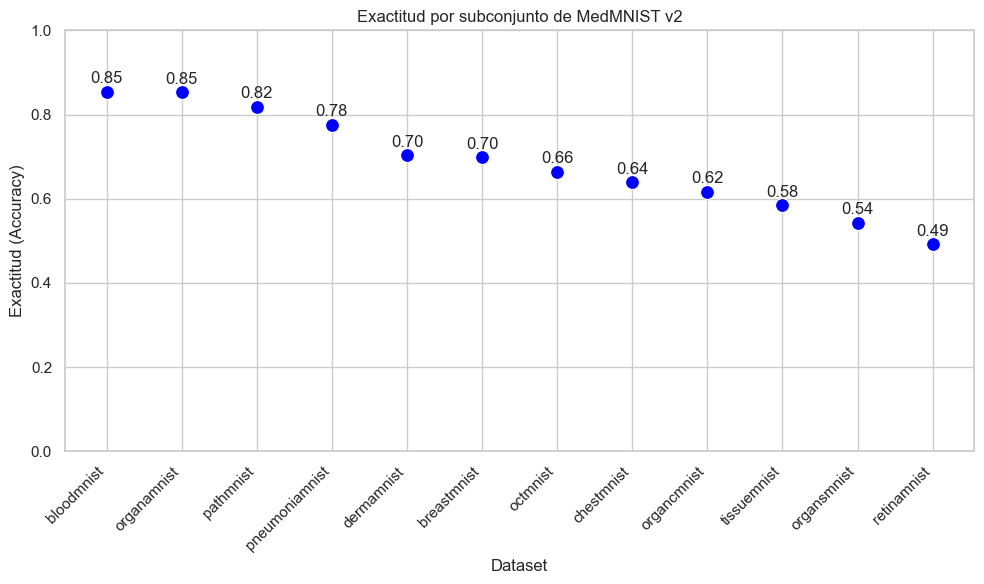

In [6]:
# Extraer nombres de datasets y su exactitud
datasets = list(data["metricas_prueba"]["detalle_por_dataset"].keys())
accuracy = [data["metricas_prueba"]["detalle_por_dataset"][d]["exactitud"] for d in datasets]

# Crear scatter plot
plt.figure(figsize=(10,6))
sns.scatterplot(x=datasets, y=accuracy, s=100, color="blue")
plt.xticks(rotation=45, ha="right")
plt.ylim(0,1)
plt.ylabel("Exactitud (Accuracy)")
plt.xlabel("Dataset")
plt.title("Exactitud por subconjunto de MedMNIST v2")
for i, a in enumerate(accuracy):
    plt.text(i, a+0.02, f"{a:.2f}", ha="center")
plt.tight_layout()
plt.show()


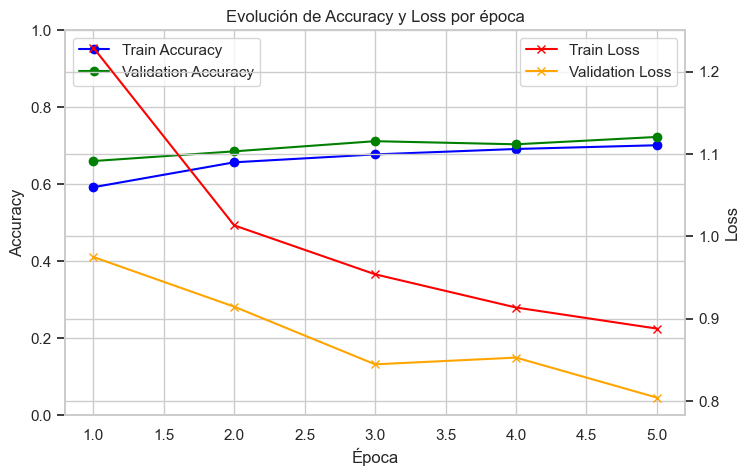

In [7]:
# Extraer historial por época
epocas = [h["epoca"] for h in data["historial_epocas"]]
train_acc = [h["exactitud_entrenamiento"] for h in data["historial_epocas"]]
val_acc = [h["exactitud_validacion"] for h in data["historial_epocas"]]
train_loss = [h["perdida_entrenamiento"] for h in data["historial_epocas"]]
val_loss = [h["perdida_validacion"] for h in data["historial_epocas"]]

# Crear figura con dos ejes y 2 gráficos
fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(epocas, train_acc, marker='o', label="Train Accuracy", color='blue')
ax1.plot(epocas, val_acc, marker='o', label="Validation Accuracy", color='green')
ax1.set_xlabel("Época")
ax1.set_ylabel("Accuracy")
ax1.set_ylim(0,1)
ax1.legend(loc='upper left')

# Crear segundo eje para loss
ax2 = ax1.twinx()
ax2.plot(epocas, train_loss, marker='x', label="Train Loss", color='red')
ax2.plot(epocas, val_loss, marker='x', label="Validation Loss", color='orange')
ax2.set_ylabel("Loss")
ax2.legend(loc='upper right')

plt.title("Evolución de Accuracy y Loss por época")
plt.show()
